In [7]:
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
# SIMPLIFIED EFFICIENT ZARR SAVING
# Focus: Proper parallelism, simple and reliable
# Removed complex auto-detection that might cause issues

import os
import time
import xarray as xr
from numcodecs import Blosc
import gcsfs

# Re-use a global filesystem client when possible
gcs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')

def save_dataset_efficient_zarr(
    ds,
    zarr_path,
    chunk_sizes=None,
    compression='lz4',
    compression_level=1,
    overwrite=True,
    consolidated=True,
    storage='auto',
    gcs_project=None,
):
    """
    Simplified zarr saving – focuses on reliable parallelism.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset to save (lazy dask arrays or in-memory).
    zarr_path : str
        Destination path or GCS URI (e.g. gs://bucket/path.zarr).
    chunk_sizes : dict, optional
        Chunk sizes per dimension (e.g. {'time': 20, 'x': 256, 'y': 256}).
    compression : {'lz4','blosc','zstd',None} or dict
        Built-in compressor choice or explicit encoding dict.
    compression_level : int
        Compression level (1 fastest, 9 best compression).
    overwrite : bool
        Overwrite existing zarr store.
    consolidated : bool
        Create consolidated metadata (recommended).
    storage : {'auto','local','gcs'}
        Force storage backend or infer from path when 'auto'.
    gcs_project : str, optional
        Explicit GCP project for a fresh filesystem client.

    Returns
    -------
    str
        The zarr_path that was written.
    """
    def _format_size(num_bytes: int) -> str:
        size_mb = num_bytes / (1024 * 1024)
        size_gb = size_mb / 1024
        return f"{size_gb:.2f} GB" if size_gb >= 1 else f"{size_mb:.2f} MB"

    start_time = time.time()

    storage = storage.lower()
    if storage == 'auto':
        storage = 'gcs' if zarr_path.startswith('gs://') else 'local'
    if storage not in {'local', 'gcs'}:
        raise ValueError("storage must be one of {'auto', 'local', 'gcs'}")

    fs = None
    if storage == 'gcs':
        fs = gcs if gcs_project is None else gcsfs.GCSFileSystem(project=gcs_project)
    else:
        zarr_dir = os.path.dirname(zarr_path) if os.path.dirname(zarr_path) else '.'
        if zarr_dir and not os.path.exists(zarr_dir):
            os.makedirs(zarr_dir, exist_ok=True)

    # Handle overwrite
    if storage == 'gcs':
        if fs.exists(zarr_path):
            if not overwrite:
                raise FileExistsError(
                    f"Zarr store already exists on GCS: {zarr_path}\n"
                    "Set overwrite=True to replace it."
                )
            print(f"🗑️  Removing existing GCS zarr store: {zarr_path}")
            fs.rm(zarr_path, recursive=True)
    else:
        if os.path.exists(zarr_path):
            if not overwrite:
                raise FileExistsError(
                    f"Zarr store already exists: {zarr_path}\n"
                    "Set overwrite=True to replace it."
                )
            import shutil
            print(f"🗑️  Removing existing zarr store: {zarr_path}")
            shutil.rmtree(zarr_path)

    # Default chunk sizes
    if chunk_sizes is None:
        chunk_sizes = {}
        dims = ds.dims
        if 'time' in dims:
            chunk_sizes['time'] = min(20, dims['time'])
        if 'x' in dims:
            chunk_sizes['x'] = min(256, dims['x'])
        if 'y' in dims:
            chunk_sizes['y'] = min(256, dims['y'])
        for dim_name, dim_len in dims.items():
            chunk_sizes.setdefault(dim_name, min(100, dim_len))

    print(f"📦 Saving to zarr: {zarr_path}")
    print(f"   Dimensions: {dict(ds.dims)}")
    print(f"   Chunks: {chunk_sizes}")
    print(f"   Compression: {compression} (level {compression_level})")
    print(f"   Storage: {storage}")

    # Prepare compression
    if compression == 'lz4':
        compressor = Blosc(cname='lz4', clevel=compression_level, shuffle=Blosc.SHUFFLE, blocksize=0)
        encoding = {var: {'compressor': compressor} for var in ds.data_vars}
    elif compression == 'blosc':
        compressor = Blosc(cname='blosclz', clevel=compression_level, shuffle=Blosc.SHUFFLE, blocksize=0)
        encoding = {var: {'compressor': compressor} for var in ds.data_vars}
    elif compression == 'zstd':
        compressor = Blosc(cname='zstd', clevel=compression_level, shuffle=Blosc.SHUFFLE, blocksize=0)
        encoding = {var: {'compressor': compressor} for var in ds.data_vars}
    elif compression is None:
        encoding = {}
    else:
        encoding = compression  # assume dict supplied

    # Chunk and save
    ds_chunked = ds.chunk(chunk_sizes)
    print("💾 Writing to zarr (with automatic parallelism)...")

    store = fs.get_mapper(zarr_path) if storage == 'gcs' else zarr_path
    try:
        from dask.diagnostics import ProgressBar
        with ProgressBar():
            ds_chunked.to_zarr(
                store,
                mode='w',
                encoding=encoding,
                consolidated=consolidated,
                compute=True,
            )
    except ImportError:
        ds_chunked.to_zarr(
            store,
            mode='w',
            encoding=encoding,
            consolidated=consolidated,
            compute=True,
        )

    elapsed = time.time() - start_time

    # Size reporting
    total_size = None
    if storage == 'gcs':
        try:
            size_info = fs.du(zarr_path)
            if isinstance(size_info, dict):
                total_size = sum(size_info.values())
            elif isinstance(size_info, (int, float)):
                total_size = size_info
        except Exception as exc:
            print(f"⚠️  Could not compute GCS store size: {exc}")
    else:
        if os.path.exists(zarr_path):
            total_size = 0
            for dirpath, _, filenames in os.walk(zarr_path):
                for f in filenames:
                    fp = os.path.join(dirpath, f)
                    total_size += os.path.getsize(fp)

    if total_size is not None:
        size_str = _format_size(total_size)
        write_speed = total_size / elapsed / (1024 * 1024)
        print("✅ Dataset saved successfully!")
        print(f"   Store size: {size_str}")
        print(f"   Time: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
        print(f"   Write speed: {write_speed:.1f} MB/s")
        print(f"   Path: {zarr_path}")
    else:
        print("✅ Dataset saved successfully! (size unavailable)")
        print(f"   Time: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")
        print(f"   Path: {zarr_path}")

    return zarr_path


def load_dataset_zarr(zarr_path, consolidated=True, storage='auto', gcs_project=None):
    """
    Load a dataset from a zarr store located locally or on GCS.
    """
    storage = storage.lower()
    if storage == 'auto':
        storage = 'gcs' if zarr_path.startswith('gs://') else 'local'
    if storage not in {'local', 'gcs'}:
        raise ValueError("storage must be one of {'auto', 'local', 'gcs'}")

    if storage == 'gcs':
        fs = gcs if gcs_project is None else gcsfs.GCSFileSystem(project=gcs_project)
        if not fs.exists(zarr_path):
            raise FileNotFoundError(f"Zarr store not found on GCS: {zarr_path}")
        mapper = fs.get_mapper(zarr_path)
        print(f"📂 Loading dataset from GCS zarr: {zarr_path}")
        ds = xr.open_zarr(mapper, consolidated=consolidated)
    else:
        if not os.path.exists(zarr_path):
            raise FileNotFoundError(f"Zarr store not found: {zarr_path}")
        print(f"📂 Loading dataset from zarr: {zarr_path}")
        ds = xr.open_zarr(zarr_path, consolidated=consolidated)

    print(f"✅ Dataset loaded: {dict(ds.dims)}")
    return ds


print("✅ Simplified zarr saving functions loaded!")
print("\nKey simplifications:")
print("  - No complex auto-detection")
print("  - Always uses compute=True (let dask handle parallelism)")
print("  - Simple, reliable, focuses on parallelism")
print("  - Works with both lazy and in-memory arrays")


✅ Simplified zarr saving functions loaded!

Key simplifications:
  - No complex auto-detection
  - Always uses compute=True (let dask handle parallelism)
  - Simple, reliable, focuses on parallelism
  - Works with both lazy and in-memory arrays


In [9]:
zarr_path = os.getenv('GCS_ZARR_DIR') + '/ds_resampled.zarr'
storage = 'gcs'

ds_resampled = load_dataset_zarr(zarr_path, storage=storage)
ds_resampled


📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_resampled.zarr
✅ Dataset loaded: {'time': 81, 'x': 4489, 'y': 3213}


/tmp/ipykernel_2049/411130122.py:214: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


<xarray.Dataset> Size: 9GB
Dimensions:   (time: 81, x: 4489, y: 3213)
Coordinates:
    image_id  (time) <U17 6kB dask.array<chunksize=(40,), meta=np.ndarray>
  * time      (time) datetime64[ns] 648B 2018-02-15 2018-05-15 ... 2025-08-15
  * x         (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y         (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
Data variables:
    EVI       (time, x, y) float32 5GB dask.array<chunksize=(40, 1024, 1024), meta=np.ndarray>
    NDVI      (time, x, y) float32 5GB dask.array<chunksize=(40, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [10]:
print(ds_resampled)

<xarray.Dataset> Size: 9GB
Dimensions:   (time: 81, x: 4489, y: 3213)
Coordinates:
    image_id  (time) <U17 6kB dask.array<chunksize=(40,), meta=np.ndarray>
  * time      (time) datetime64[ns] 648B 2018-02-15 2018-05-15 ... 2025-08-15
  * x         (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y         (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
Data variables:
    EVI       (time, x, y) float32 5GB dask.array<chunksize=(40, 1024, 1024), meta=np.ndarray>
    NDVI      (time, x, y) float32 5GB dask.array<chunksize=(40, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749


In [11]:
#### DS TRAIN CHECK RESAMPLING
import geopandas as gpd
training_gdf = gpd.read_file('00_input/training_shp/example_result_2.shp')
training_gdf.head()

,t_202509,t_202506,t_202503,t_202412,t_202409,t_202406,t_202403,t_202312,t_202309,t_202306,...,t_202312_D,t_202403_D,t_202406_D,t_202409_D,t_202412_D,t_202503_D,t_202506_D,t_202509_D,detect_inc,geometry
0,0,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,1,"POLYGON ((591131.092 9954374.839, 591129.050 9..."
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,1,0,0,1,"POLYGON ((591122.289 9954600.447, 591122.614 9..."
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((590775.461 9954035.522, 590773.632 9..."
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,"POLYGON ((590334.436 9954715.347, 590348.333 9..."
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,"MULTIPOLYGON (((590602.369 9954069.183, 590589..."


<Axes: >

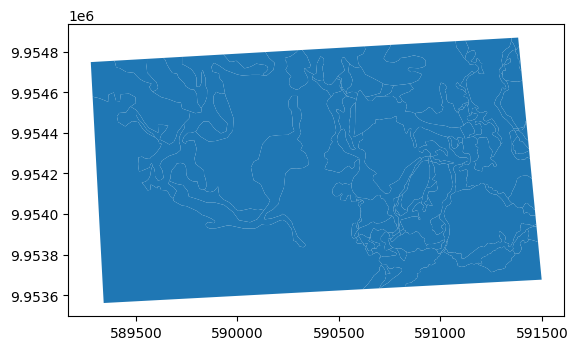

In [12]:
training_gdf.plot()

In [13]:
# training_gdf.head()

In [14]:
training_gdf.columns

Index(['t_202509', 't_202506', 't_202503', 't_202412', 't_202409', 't_202406',
       't_202403', 't_202312', 't_202309', 't_202306', 't_202303', 't_202212',
       't_202209', 't_202206', 't_202203', 't_202112', 't_202109', 't_202106',
       't_202103', 't_202012', 't_202009', 't_202006', 't_202003', 't_201912',
       't_201909', 't_201906', 't_201903', 't_201812', 't_201809', 't_201806',
       't_201803', 't_201712', 't_201709', 't_201706', 't_201703', 't_201612',
       't_201703_D', 't_201706_D', 't_201709_D', 't_201712_D', 't_201803_D',
       't_201806_D', 't_201809_D', 't_201812_D', 't_201903_D', 't_201906_D',
       't_201909_D', 't_201912_D', 't_202003_D', 't_202006_D', 't_202009_D',
       't_202012_D', 't_202103_D', 't_202106_D', 't_202109_D', 't_202112_D',
       't_202203_D', 't_202206_D', 't_202209_D', 't_202212_D', 't_202303_D',
       't_202306_D', 't_202309_D', 't_202312_D', 't_202403_D', 't_202406_D',
       't_202409_D', 't_202412_D', 't_202503_D', 't_202506_D', '

In [15]:
import pandas as pd

# Get all columns that start with 't_'
t_cols = ['t_202509', 't_202506', 't_202503', 't_202412', 't_202409', 't_202406',
       't_202403', 't_202312', 't_202309', 't_202306', 't_202303', 't_202212',
       't_202209', 't_202206', 't_202203', 't_202112', 't_202109', 't_202106',
       't_202103', 't_202012', 't_202009', 't_202006', 't_202003', 't_201912',
       't_201909', 't_201906', 't_201903', 't_201812', 't_201809', 't_201806',
       't_201803', 't_201712', 't_201709', 't_201706', 't_201703', 't_201612']

# Melt the dataframe with geometry as id_var
df_long = pd.melt(
    training_gdf, 
    id_vars=['geometry'],
    value_vars=t_cols,
    var_name='time_period',
    value_name='value'
)

# Set geometry as index
df_long = df_long.set_index('geometry')

print(f"Original shape: {training_gdf.shape}")
print(f"Long format shape: {df_long.shape}")
print(f"Time columns found: {len(t_cols)}")
print(f"\nFirst few rows:")
df_long.head()


Original shape: (110, 73)
Long format shape: (3960, 2)
Time columns found: 36

First few rows:


,time_period,value
geometry,,
"POLYGON ((591131.092 9954374.839, 591129.050 9...",t_202509,0
"POLYGON ((591122.289 9954600.447, 591122.614 9...",t_202509,1
"POLYGON ((590775.461 9954035.522, 590773.632 9...",t_202509,0
"POLYGON ((590334.436 9954715.347, 590348.333 9...",t_202509,1
"MULTIPOLYGON (((590602.369 9954069.183, 590589...",t_202509,1


<Axes: >

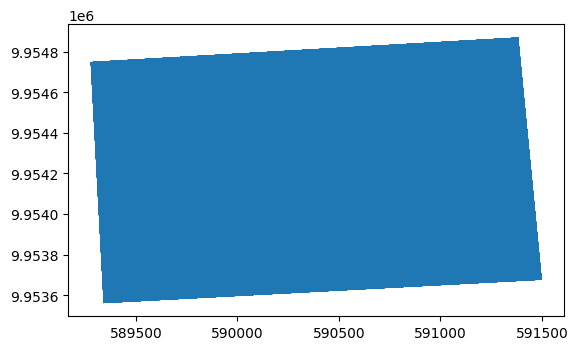

In [16]:
df_long.reset_index(inplace=True)
df_long.head()
df_long.plot()


In [17]:
df_long

,geometry,time_period,value
0,"POLYGON ((591131.092 9954374.839, 591129.050 9...",t_202509,0
1,"POLYGON ((591122.289 9954600.447, 591122.614 9...",t_202509,1
2,"POLYGON ((590775.461 9954035.522, 590773.632 9...",t_202509,0
3,"POLYGON ((590334.436 9954715.347, 590348.333 9...",t_202509,1
4,"MULTIPOLYGON (((590602.369 9954069.183, 590589...",t_202509,1
...,...,...,...
3955,"POLYGON ((591134.018 9954532.610, 591136.315 9...",t_201612,1
3956,"MULTIPOLYGON (((590530.695 9954590.598, 590528...",t_201612,1
3957,"POLYGON ((590552.864 9954740.720, 590550.229 9...",t_201612,1
3958,"POLYGON ((590811.549 9954558.918, 590830.373 9...",t_201612,1


In [18]:
test = 't_202509'
test[2:]


'202509'

In [19]:
df_long = df_long.rename(columns={'value': 'type'})
df_long['date'] = df_long['time_period'].str[2:].astype(int)
df_long.head()


,geometry,time_period,type,date
0,"POLYGON ((591131.092 9954374.839, 591129.050 9...",t_202509,0,202509
1,"POLYGON ((591122.289 9954600.447, 591122.614 9...",t_202509,1,202509
2,"POLYGON ((590775.461 9954035.522, 590773.632 9...",t_202509,0,202509
3,"POLYGON ((590334.436 9954715.347, 590348.333 9...",t_202509,1,202509
4,"MULTIPOLYGON (((590602.369 9954069.183, 590589...",t_202509,1,202509


In [20]:
type(df_long)

geopandas.geodataframe.GeoDataFrame

In [21]:
training_gdf = df_long.copy()
# Remove multipolygons
size = len(training_gdf)
training_gdf = training_gdf.explode()

/tmp/ipykernel_2049/2945178216.py:4: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  training_gdf = training_gdf.explode()


In [43]:
try:
    assert size == len(training_gdf)
except AssertionError:
    print(f'Exploded training_gdf failed')

In [44]:
#####
training_gdf['date'] = pd.to_datetime(training_gdf['date'], format='%Y%m')

# add year columnt
training_gdf['year'] = training_gdf['date'].dt.year

# convert column 'type' from string to int
training_gdf['type'] = training_gdf['type'].astype(int)

In [53]:
# training_gdf['date']

In [46]:
# training_gdf['year']

In [54]:
import numpy as np
import rasterio
from affine import Affine
import rasterio.features

def get_raster_mask(date, ds, gdf):
    gdf_1 = gdf[gdf['type'] == 1]
    gdf_0 = gdf[gdf['type'] == 0]

    gdf_1 = gdf_1.dissolve(by='date')
    gdf_0 = gdf_0.dissolve(by='date')


    trees = gdf_1[gdf_1.index == date]
    non_trees = gdf_0[gdf_0.index == date]

    features = [(geom, 1) for geom in trees.geometry] + [(geom, 0) for geom in non_trees.geometry]

    # Assuming the dataset has evenly spaced coordinates named 'x' and 'y'
    x = ds.coords['x'].values
    y = ds.coords['y'].values

    # Calculate pixel resolution. 
    # Here we assume x is increasing and y is decreasing (common for image data)
    res_x = (x[-1] - x[0]) / (len(x) - 1)
    res_y = (y[0] - y[-1]) / (len(y) - 1)

    # Construct an affine transform.
    # The translation moves to the center of the top-left pixel.
    transform = Affine.translation(x[0] - res_x / 2, y[0] + res_y / 2) * Affine.scale(res_x, -res_y)

    mask_raster = rasterio.features.rasterize(
            features, 
            # [(geom, 1) for geom in gdf_1.geometry],
            out_shape=(len(y), len(x)),
            transform=transform,
            fill=np.nan,
            dtype="float32"
    )

    # Optionally wrap the raster in an xarray DataArray using ds coordinates
    mask_da = xr.DataArray(
        mask_raster,
        dims=("y", "x"),
        coords={"y": ds.coords["y"], "x": ds.coords["x"], "date": date},
    )

    return mask_da

In [55]:
ds_resampled

<xarray.Dataset> Size: 9GB
Dimensions:   (time: 81, x: 4489, y: 3213)
Coordinates:
    image_id  (time) <U17 6kB dask.array<chunksize=(40,), meta=np.ndarray>
  * time      (time) datetime64[ns] 648B 2018-02-15 2018-05-15 ... 2025-08-15
  * x         (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y         (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
Data variables:
    EVI       (time, x, y) float32 5GB dask.array<chunksize=(40, 1024, 1024), meta=np.ndarray>
    NDVI      (time, x, y) float32 5GB dask.array<chunksize=(40, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [56]:
masks = []
for date in list(training_gdf.date.unique()):
    mask = get_raster_mask(date, ds_resampled, training_gdf)
    masks.append(mask)

In [57]:
masks

[<xarray.DataArray (y: 3213, x: 4489)> Size: 58MB
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
 Coordinates:
   * y        (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
   * x        (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
     date     datetime64[ns] 8B 2025-09-01,
 <xarray.DataArray (y: 3213, x: 4489)> Size: 58MB
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
 Coordinates:
   * y        (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
   * 

In [58]:
# merge mask_da_2021 and mask_da_2021 
mask_da = xr.concat(masks, dim='date')

# create mask that will containt True if all pixles in year range have valid value (ie. not nan)
mask = mask_da.notnull().all(dim='date')

In [59]:
mask

<xarray.DataArray (y: 3213, x: 4489)> Size: 14MB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * y        (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
  * x        (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05

In [71]:
# convert to dataset 
gt = mask_da.to_dataset(name='ground_truth')
gt['valid'] = mask

In [72]:
gt

<xarray.Dataset> Size: 2GB
Dimensions:       (y: 3213, x: 4489, date: 36)
Coordinates:
  * y             (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
  * x             (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * date          (date) datetime64[ns] 288B 2025-09-01 ... 2016-12-01
Data variables:
    ground_truth  (date, y, x) float32 2GB nan nan nan nan ... nan nan nan nan
    valid         (y, x) bool 14MB False False False False ... False False False

In [73]:
gt.date

<xarray.DataArray 'date' (date: 36)> Size: 288B
array(['2025-09-01T00:00:00.000000000', '2025-06-01T00:00:00.000000000',
       '2025-03-01T00:00:00.000000000', '2024-12-01T00:00:00.000000000',
       '2024-09-01T00:00:00.000000000', '2024-06-01T00:00:00.000000000',
       '2024-03-01T00:00:00.000000000', '2023-12-01T00:00:00.000000000',
       '2023-09-01T00:00:00.000000000', '2023-06-01T00:00:00.000000000',
       '2023-03-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000',
       '2022-09-01T00:00:00.000000000', '2022-06-01T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000', '2021-12-01T00:00:00.000000000',
       '2021-09-01T00:00:00.000000000', '2021-06-01T00:00:00.000000000',
       '2021-03-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000',
       '2020-09-01T00:00:00.000000000', '2020-06-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000', '2019-06-01T00:00:00.000000000',
       '2019-03-01T00:00:00.000000000', '2018-12-01T00:00:00.000000000',
       '2018-09-01T00:00:00.000000000', '2018-06-01T00:00:00.000000000',
       '2018-03-01T00:00:00.000000000', '2017-12-01T00:00:00.000000000',
       '2017-09-01T00:00:00.000000000', '2017-06-01T00:00:00.000000000',
       '2017-03-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * date     (date) datetime64[ns] 288B 2025-09-01 2025-06-01 ... 2016-12-01

In [74]:
### INPUT
resampling_freq = 'MS'
# gt.date is already datetime, so just convert to pandas Timestamp
start_date = pd.Timestamp(gt.date.min().values)
cut_off_date = pd.Timestamp(gt.date.max().values)
print(f"Start date: {start_date}")
print(f"Cut-off date: {cut_off_date}")
cut_off_date

Start date: 2016-12-01 00:00:00
Cut-off date: 2025-09-01 00:00:00


Timestamp('2025-09-01 00:00:00')

In [77]:
# plot_gt_mask(gdf, gt, show=True, save=False)
# plot_gt_usable_data(gt, show=True, save=False)

# convert yeart in gt from int to datetime
# gt['date'] = pd.to_datetime(gt['date'].astype(str),  format='%Y%-m')

gt = gt.sortby('date').rename({'date': 'time'})
monthly_time = pd.date_range(start_date, cut_off_date, freq=resampling_freq)
# This will repeat the value from January 1 throughout the year until the next available time.
gt = gt.reindex(time=monthly_time, method='ffill').sortby('time')

: 

: 

: 